# Surface Event Pick Time

This is a modified version of the surface-event location+directivity analysis that Francesca Skene ( fskene@uw.edu), originally created by her in 7/22/22, who started as an undergraduate student at UW. This is marine denolle's version. It includes:
* Waveform download for each event on each volcano given the PNSN pick times of "su" events.
* Data pre-processing to trim the data within 2-12 Hz and remove outliers.
* phase picking using transfer-learned model (Ni et al, 2023)
* event location using 1D grid search
* directivity measurements (velocity and direction) using Doppler effects.
* gathering of the data into a CSV data frame.

Updated 02/1/2024
Marine Denolle
(mdenolle@uw.edu)

Import Modules

In [1]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client

import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from datetime import datetime
from utils import *
from mbf_elep_func import *
import torch
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu")

# from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
# from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
import pyproj

Parameters

In [2]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS')

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 7 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2024,1,1,23,59)

smooth_length = 20 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 15 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
# colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

## Volcano - Station Information

In [3]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

## PNSN SU Pick information

In [4]:
# f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
# f1.head()
# print(f1.keys())

In [5]:
# # clean up the spaces in the file
# format='%Y/%m/%d %H:%M:%S'
# test=f1["date"].values.tolist()
# start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # # Ignore events prior to t_beginning
# ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# # select only net, sta, evid, startime for event past the start date.

# start_time = start_time_temp[ik:]
# net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
# sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
# evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
# all_stas=set(sta)

## ML Models

In [6]:
# import os
# os.makedirs("/Users/marinedenolle/.seisbench/models/v3/eqtransformer",exist_ok=True)

In [7]:
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.pt.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.pt.v1
# !wget https://github.com/congcy/ELEP/raw/main/docs/tutorials/data/pnw.json.v1 -O ~/.seisbench/models/v3/eqtransformer/pnw.json.v1

In [8]:
# download models
list_models_name = ["pnw","ethz","instance","scedc","stead","geofon"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
# pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_pnw_model, pn_ethz_model, pn_instance_model, pn_scedc_model, pn_stead_model, pn_geofon_model]

pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
# pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

In [9]:
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

fqmin = low_cut
fqmax = high_cut
dt = 0.025; fs = 40
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

# Full stack:

* download waveforms
* phase pick onset
* estimate SNR
* measure centroid, max envelope, duration
* measure Fmax for doppler analysis


ARAT 40.525 73.93419402737266
OBSR 39.35 71.86981085562702
PANH 37.825 75.47713852805157
PARA 36.775 78.37906620354063
PR04 41.125 73.59691573880455
PR05 40.225 72.26552312563393
RUSH 41.375 72.61820321641147
SIFT 40.475 75.31383632294848
LO2 46.725 77.5492968711363
LON 46.65 77.52189100597839
RCM 38.3 72.65320577374096
RCS 39.175 67.94199428824098
RER 44.125 74.40549323560873
                          otime nets  stas        snr  smb_peak  max_time  \
0   2023-12-10T12:19:00.000000Z   CC  ARAT  20.385755     9.375    25.525   
1   2023-12-10T12:19:00.000000Z   CC  OBSR  13.015297     9.875    24.350   
2   2023-12-10T12:19:00.000000Z   CC  PANH  25.845379    10.025    22.825   
3   2023-12-10T12:19:00.000000Z   CC  PARA  29.701416     8.350    21.775   
4   2023-12-10T12:19:00.000000Z   CC  PR04   7.045119   -15.000    26.125   
5   2023-12-10T12:19:00.000000Z   CC  PR05  10.672577    11.850    25.225   
6   2023-12-10T12:19:00.000000Z   CC  RUSH  11.981717    11.075    26.375   
7   

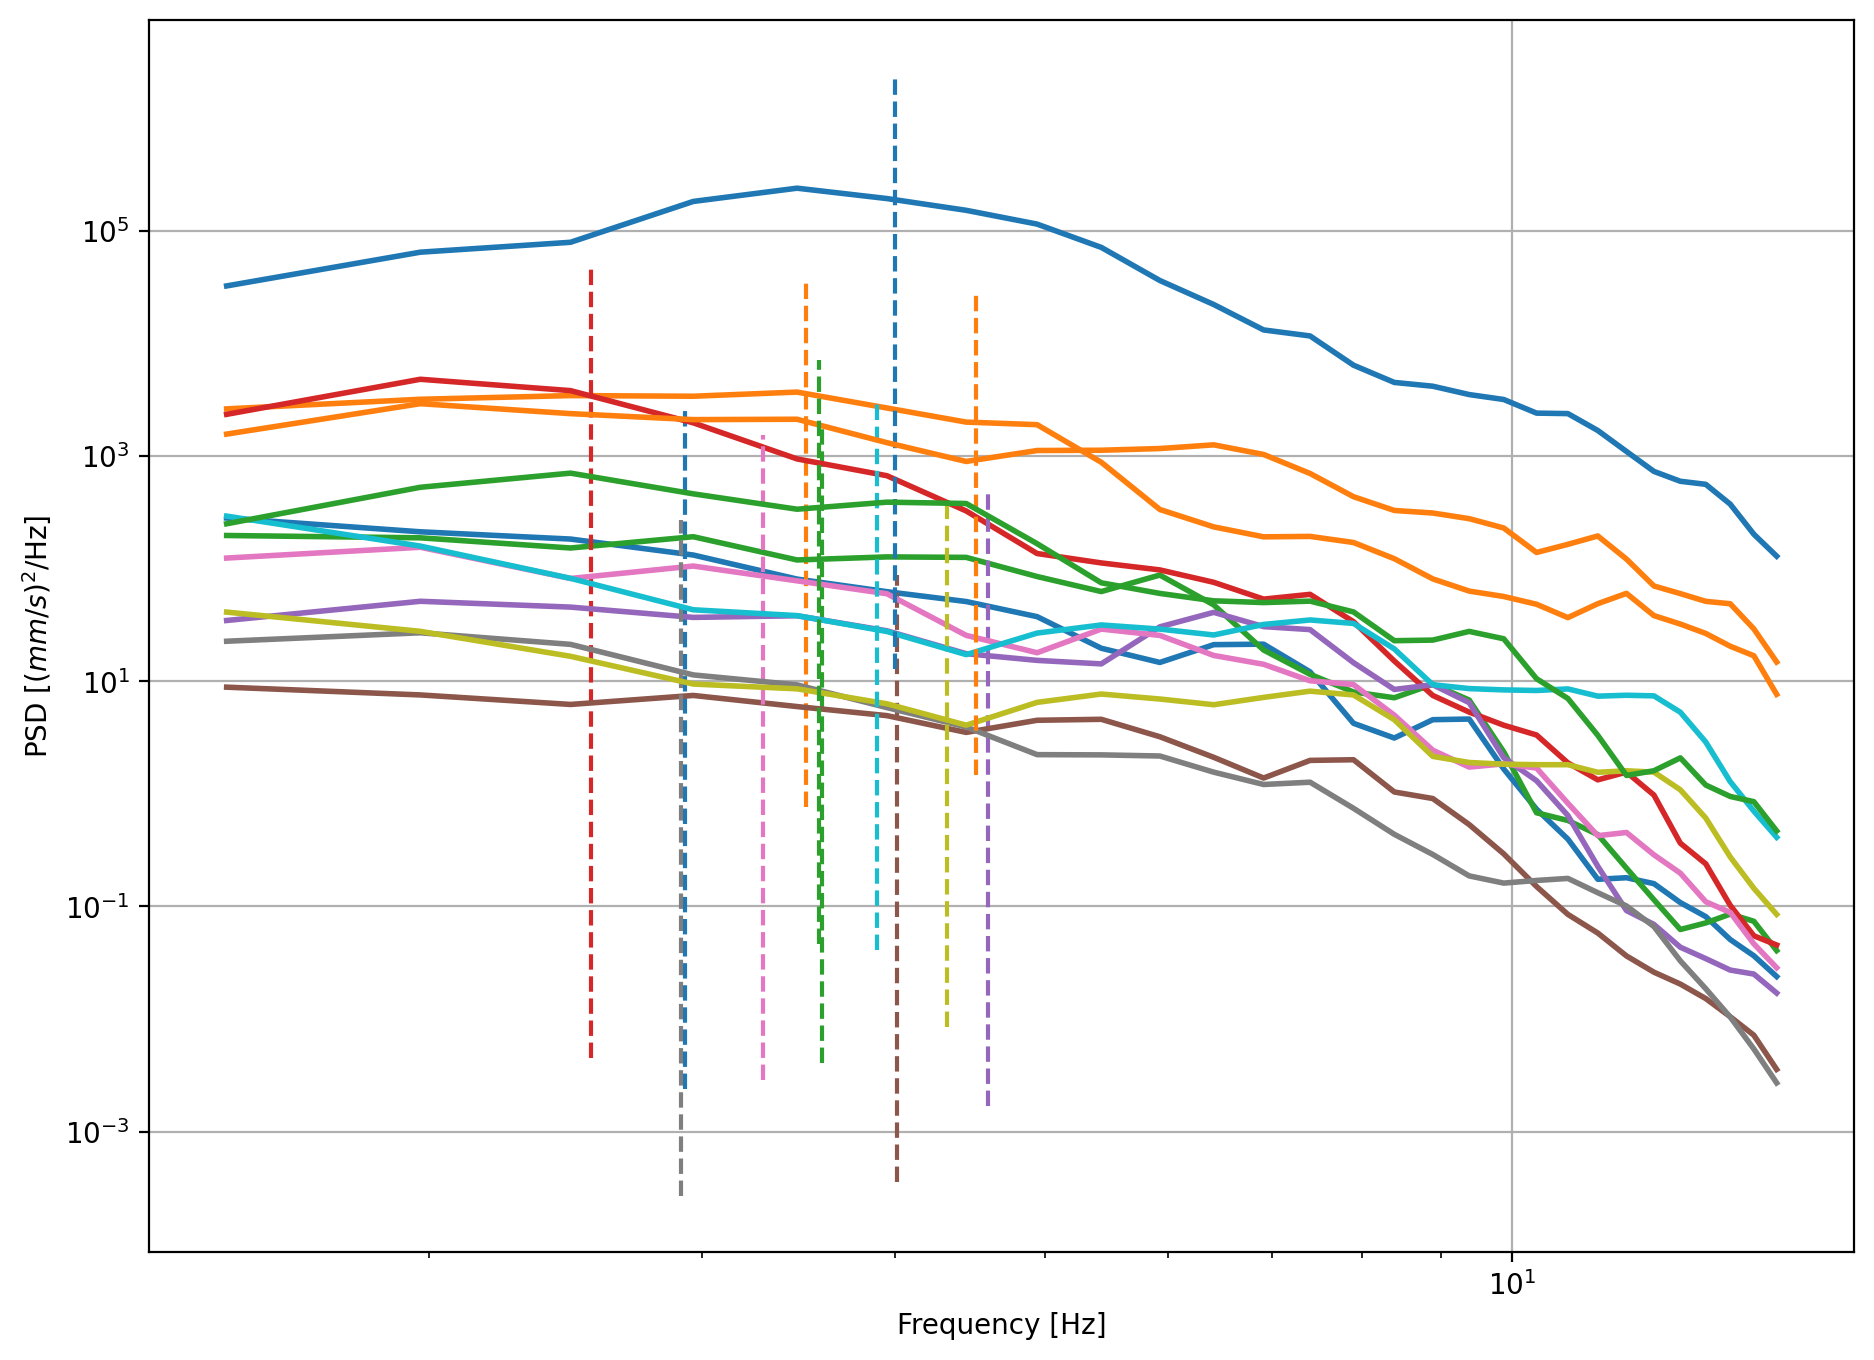

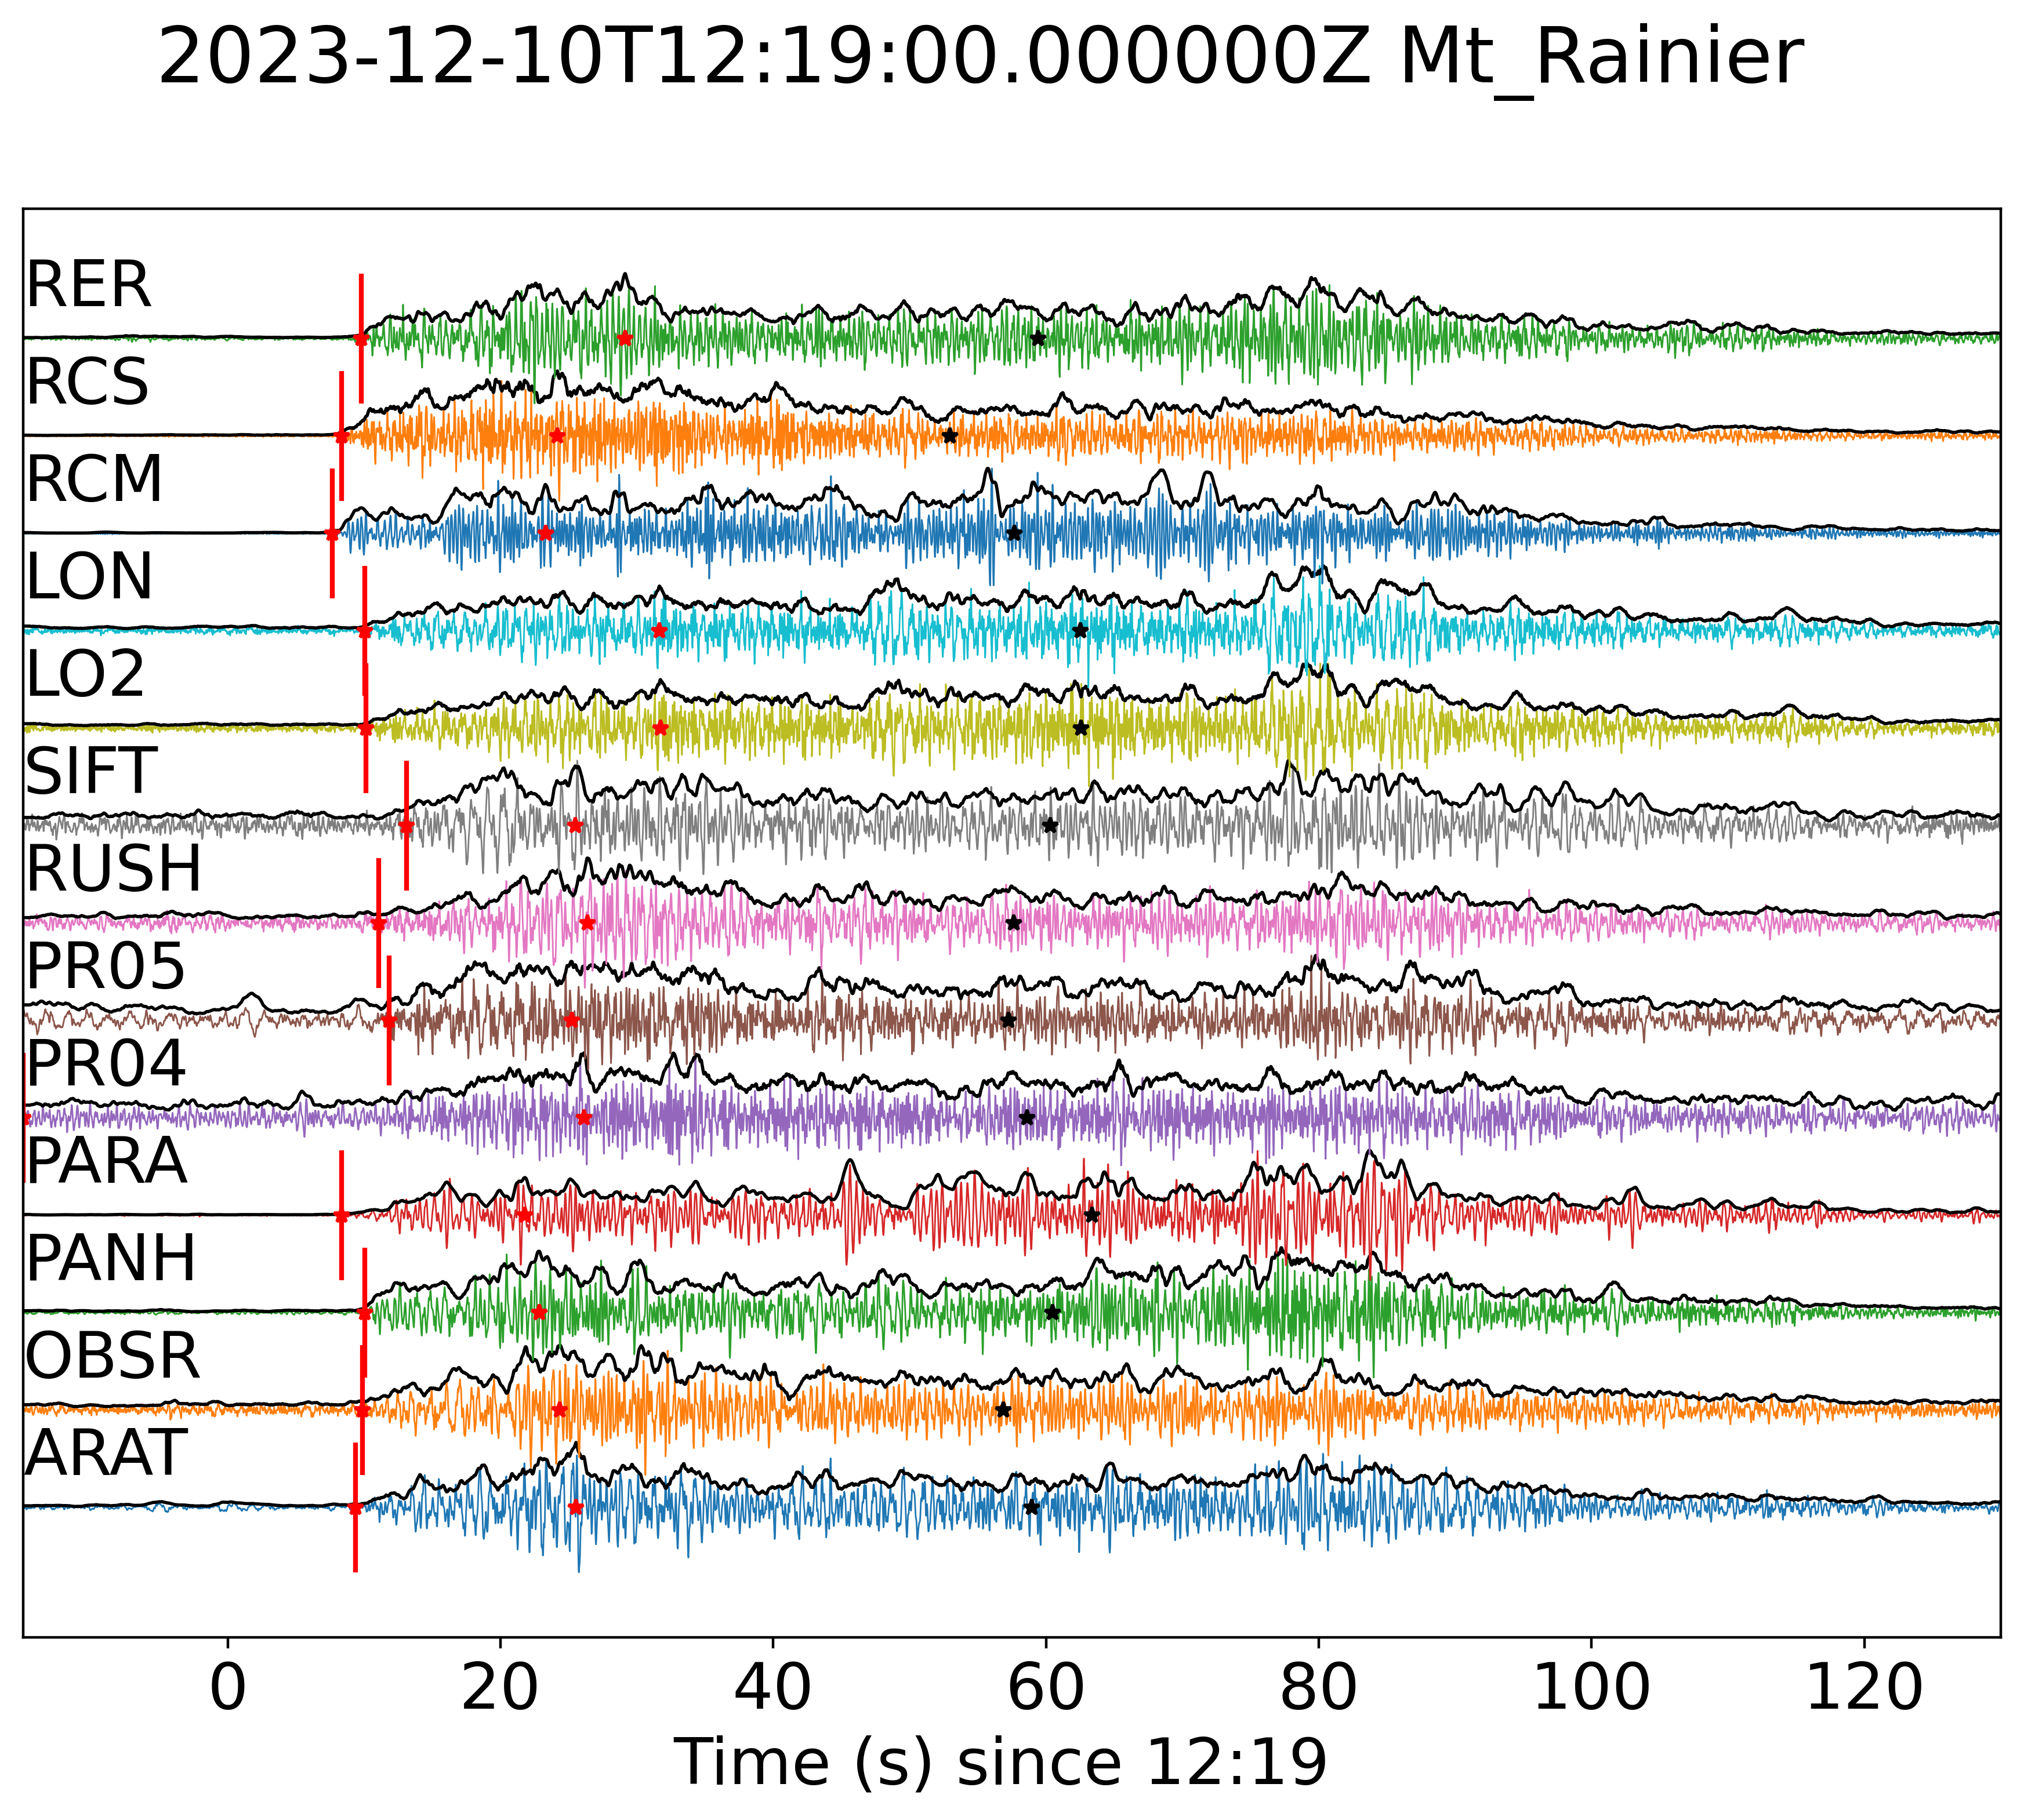

<Figure size 640x480 with 0 Axes>

In [10]:

pdf = PdfPages('../plots/Avalanche_121023.pdf')
associated_volcano = "Mt_Rainier"
dff=[] 
event_ID = '0000' #str(evt_id[n])
otime = UTCDateTime(2023,12,10,12,19)
associated_volcano="Mt_Rainier"


#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()


#################### WAVEFORM DOWNLOAD #######################
#Download all waveforms for that event based on stations and times
bulk = [] 
for m in range(0, len(networks)):
    bulk.append([networks[m], stations[m], '*', '*Z', otime-t_before_raw, otime+t_before_raw])
# try:
st = client2.get_waveforms_bulk(bulk)
st = resample(st,fs)  #resampling the data to 40Hz for each trace
evt_data = obspy.Stream()
snr=[]
stas=[]
nets=[]
lats=[]
lons=[]
els=[]
centroid_time = []
data_env_dict = {}
duration = []
max_time = []

# #Keeping all traces for one event with channel z, SNR>10, and bandpassed between 2-12Hz
# ,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
for i,ii in enumerate(st):
    ii.detrend(type = 'demean')
    ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
    # trim the data and noise window to exactly 6000 points
    signal_window = ii.copy()
    noise_window = ii.copy()
    signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
    noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
    if  len(signal_window.data)<=10 or  len(noise_window.data)<=10: continue # skip if no data
    # if not np.percentile(np.abs(signal_window.data),pr):continue # skip if max amplitude is zero
    snr1 = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                    / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
    if snr1<thr: # and 100<max_amp_time<200:
        st.remove(ii)
        continue

################# ENVELOPE, CENTROID, DURATION #######################
    # enveloping the data 
    data_envelope = obspy.signal.filter.envelope(signal_window.data)
    data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)

    data_env_dict[ii.stats.network+'.'+ii.stats.station]= data_envelope/max(np.abs(data_envelope))


    # max time
    # finding the time of max amplitude of each event
    # signal_window is windowed at otime-t_v before the PNSN pick time
    crap = np.argmax(np.abs(data_envelope[:(t_before+40)*fs])) # time of max amplitude relative to otime
    max_time.append(crap/fs)

    # centroid time
    tcrap = signal_window.times()
    it = np.where(tcrap>0)[0]
    centroid_time.append(np.sum(data_envelope*tcrap)/np.sum(data_envelope))
    print(ii.stats.station,max_time[-1],centroid_time[-1])

    # find duration as data starting with the "origin time" and ending when the envelope falls below the mean noise
    noise_envelope = obspy.signal.filter.envelope(noise_window.data)
    data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
    mean_noise = np.mean(noise_envelope)
    
    mmax = np.max(np.cumsum(data_envelope**4))
    crap = np.where( np.cumsum(data_envelope**4) <= 0.999*mmax)[0][-1]
    duration.append(crap/fs)


    stas.append(ii.stats.station)
    nets.append(ii.stats.network)
    ista=stations.index(ii.stats.station)
    lats.append(latitudes[ista])
    lons.append(longitudes[ista])
    els.append(elevations[ista])
    snr.append(snr1)
    evt_data.append(signal_window)

    t = evt_data.select(station=stas[-1])[0].times()
    

centroid_time = np.asarray(centroid_time)
centroid_time -= t_before
max_time = np.asarray(max_time)
max_time -= t_before
duration = np.asarray(duration)
duration -= t_before

################### ELEP #######################

    # test the new function
smb_peak= apply_elep(evt_data, stas, \
        list_models, MBF_paras, paras_semblance, t_before)
smb_peak -= t_before


############## PEAK FREQUENCY MEASUREMENTS ############
# Given the approximate measurement of duration, window the signal windows around that
# then measure peak frequency so that there is less noise in it.
# perform this on the Z component only.

char_freq, sharp_weight= [],[]
fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
for ii,i in enumerate(evt_data):
    data = np.zeros(200*fs)
    crap=i.copy()
    otime1 = crap.stats.starttime + smb_peak[ii] # pick time
    crap.trim(otime1  - 10, otime1 + 2*duration[ii] + 10) # window the data around the pick time
    crap.taper(max_percentage=0.01,max_length=20)

    data[:len(crap.data)] = crap.data #*100
    f,psd=scipy.signal.welch(data,fs=fs,nperseg=81,noverlap=4)
    #just get the frequencies within the filter band
    above_low_cut = [f>low_cut]
    below_high_cut = [f<high_cut]
    in_band = np.logical_and(above_low_cut,below_high_cut)[0]
    f = f[in_band]
    psd = psd[in_band]

    # calculate characteristic frequency and report
    char_freq_max = f[np.argmax(psd)]
    char_freq_mean= np.sum(psd*f)/np.sum(psd)
    psd_cumsum = np.cumsum(psd)
    psd_sum = np.sum(psd)
    char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
    char_freq.append(char_freq_mean)

    plt.rcParams.update({'font.size': 20})
    p=ax.plot(f,psd,label=stas[ii],linewidth=2)
    cc = p[0].get_color()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid('True')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('PSD [$(mm/s)^2$/Hz]')
    ax.vlines(char_freq_mean,ymin=np.min(psd)/10,ymax=np.max(psd)*10,linestyle="--",colors=cc)

#             # weighting the data by the spikiness of the PSD vs frequency graphs
    ratio = (np.mean(psd)/np.max(psd))
    sharp_weight.append(int(1/(ratio**2)*20))


    ############# KEEP DATA #######################

#         if not max(smb_peak.shape):continue
ddict = {'otime':otime, 'nets':nets, 'stas':stas,  'snr':snr, 'smb_peak': smb_peak, 'max_time':max_time, 'centroid_time': centroid_time , \
         'lats':lats, 'lons':lons, 'elevs':els, 'char_freq':char_freq, 'duration':duration, \
            'sharp_weight':sharp_weight, 'volcano':associated_volcano, 'event_ID':event_ID}
if not np.any(dff):
    dff = pd.DataFrame.from_dict(ddict)
else:
    dff=pd.concat([dff,pd.DataFrame.from_dict(ddict)],ignore_index=True)
print(dff)



fig = plt.figure(figsize = (11,8), dpi=400)
fig.suptitle(str(otime)+" "+associated_volcano)
ax = plt.subplot(1,1,1)
iplot = 0
for i in range(len(stas)):
    data = evt_data.select(station=stas[i])[0].data
    max1 = np.max(np.abs(data))
    t = evt_data.select(station=stas[i])[0].times()
    ax.plot(t-t_before,data/max1+iplot*1.5,linewidth=0.5)
    if np.any(data_env_dict[nets[i]+'.'+stas[i]]):
        ax.plot(t-t_before,data_env_dict[nets[i]+'.'+stas[i]]+iplot*1.5,'k',linewidth=1)
    ax.plot(smb_peak[i],iplot*1.5,'r*',markersize=5)  
    ax.plot(centroid_time[i],iplot*1.5,'k*',markersize=5)  
    ax.plot(max_time[i],iplot*1.5,'r*',markersize=5)  
    ax.set_yticks([])
    plt.text(-15, iplot*1.5+0.5, stas[i])
    print(stas[i],snr[i])
    # if i==ista:
    # err_title=("%s %2.2f (s) error in picks"%(stas[i],smb_peak[i]-t_before))
    # plt.text(60, iplot*1.5+0.5,err_title,color='r')
    plt.vlines(smb_peak[i],iplot*1.5-1.,iplot*1.5+1.,'r')
    print(duration[i],char_freq[i],sharp_weight[i])
    # print(stas[i],smb_peak[i]-t_before)
    iplot+=1
# plt.grid(True)
ax.set_xlim([-t_before,130])
ax.set_xlabel('Time (s) since 12:19 ')
plt.show()
pdf.savefig(fig)
plt.clf()
# del fig
pdf.close()
dff.to_csv("../data/events/MLPicks_Avalanche_12102023.csv")

In [11]:
dff

otime nets  stas        snr  smb_peak  max_time  \
0   2023-12-10T12:19:00.000000Z   CC  ARAT  20.385755     9.375    25.525   
1   2023-12-10T12:19:00.000000Z   CC  OBSR  13.015297     9.875    24.350   
2   2023-12-10T12:19:00.000000Z   CC  PANH  25.845379    10.025    22.825   
3   2023-12-10T12:19:00.000000Z   CC  PARA  29.701416     8.350    21.775   
4   2023-12-10T12:19:00.000000Z   CC  PR04   7.045119   -15.000    26.125   
5   2023-12-10T12:19:00.000000Z   CC  PR05  10.672577    11.850    25.225   
6   2023-12-10T12:19:00.000000Z   CC  RUSH  11.981717    11.075    26.375   
7   2023-12-10T12:19:00.000000Z   CC  SIFT   9.802826    13.100    25.475   
8   2023-12-10T12:19:00.000000Z   UW   LO2  18.116308    10.125    31.725   
9   2023-12-10T12:19:00.000000Z   UW   LON  18.143704    10.025    31.650   
10  2023-12-10T12:19:00.000000Z   UW   RCM  30.550353     7.650    23.300   
11  2023-12-10T12:19:00.000000Z   UW   RCS  25.346499     8.325    24.175   
12  2023-12-10T12:19:00.000000Z   UW   RER  20.721783     9.800    29.125   

    centroid_time       lats        lons     elevs  char_freq  duration  \
0       58.934194  46.788755 -121.852537  1823.137   2.928169   110.300   
1       56.869811  46.899719 -121.815331  2382.000   3.505511   115.925   
2       60.477139  46.859032 -121.642592  2086.000   3.587288   108.450   
3       63.379066  46.786442 -121.742149  1651.180   2.544264   112.925   
4       58.596916  46.929694 -121.988976   912.700   4.592285   131.650   
5       57.265523  46.841649 -121.948912  1553.000   4.007991   125.625   
6       57.618203  46.903060 -121.944390  1235.000   3.284177   119.625   
7       60.313836  46.867092 -121.953246   720.900   2.908494   130.200   
8       62.549297  46.750599 -121.809601   853.000   4.317075   115.200   
9       62.521891  46.750599 -121.809601   853.000   3.893732   115.000   
10      57.653206  46.835640 -121.732979  3085.000   3.996852   102.850   
11      52.941994  46.870831 -121.732307  2877.000   4.509952    99.375   
12      59.405493  46.819050 -121.842133  1756.000   3.569310   108.125   

    sharp_weight     volcano event_ID  
0            939  Mt_Rainier     0000  
1            327  Mt_Rainier     0000  
2            288  Mt_Rainier     0000  
3           1510  Mt_Rainier     0000  
4            198  Mt_Rainier     0000  
5            269  Mt_Rainier     0000  
6            637  Mt_Rainier     0000  
7            867  Mt_Rainier     0000  
8            772  Mt_Rainier     0000  
9           1433  Mt_Rainier     0000  
10           578  Mt_Rainier     0000  
11           271  Mt_Rainier     0000  
12           577  Mt_Rainier     0000

Now locate the event

## Volcano data



In [12]:

associated_volcano == 'Mt_Rainier'
        
#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()

############ LOCATION ############################
# input necessary data for grid search
arrivals = dff['smb_peak'].values
# arrivals = dff[dff['event_ID']==event_ID]['smb_peak'].values
sta_lats = dff['lats'].values
sta_lons = dff['lons'].values


In [13]:
import pyproj


# # Define the projection: UTM zone 11 for Washington state
# proj = pyproj.Proj(proj='utm', zone=11, ellps='WGS84')

# # Convert lat/long to Cartesian in meters
# xsta, ysta = proj(sta_lons, sta_lats)

# cmap = plt.get_cmap('hot_r')
# ik=np.where(arrivals>0)[0]
# for i in ik:
#     tt = arrivals[i]-np.min(arrivals[ik])
#     nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
#     plt.plot(xsta[i],ysta[i],'o',color=cmap(tt/nmax),markersize=10,markeredgecolor='k')
#     plt.text(xsta[i],ysta[i],stas[i]+":"+str(np.ceil(tt))+" s")
#     plt.axis('equal')
# plt.title("Travel time Relative to RCM")

Now we are confident that we can do the grid search. let's check the other fields

In [14]:
# center latitude, center longitude, elevation(m), left_trim, right_trim, bottom_trim, top_trim 
volc_lat_lon = {}
volc_lat_lon['Mt_Rainier'] = [46.8528857, -121.7603744, 4392.5]
#Find the lower left corner and grid size based on volcano elevation
# define grid origin in lat,lon and grid dimensions in m
lon_start = -122 #volc_lat_lon[associated_volcano][0]
lon_end = -121.5 #volc_lat_lon[associated_volcano][0]
lat_start = 46.6 #volc_lat_lon[associated_volcano][1]
lat_end = 47 #volc_lat_lon[associated_volcano][1]


In [15]:
ista =np.where(arrivals>-t_before+0.1)[0]
t_best,lon_best,lat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],arrivals[ista],vs=1000,
                                                weight=dff['snr'].values[ista]**2)

print(t_best,lon_best,lat_best)


Now let's test this simple grid search

In [ ]:
ista =np.where(arrivals>-t_before+0.1)[0]
rss_mat,t_best,lon_best,lat_best,best_idx = gridsearch(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],arrivals[ista],vs=1000,
                                                weight=dff['snr'].values[ista]**2)

# lets plot rss_mat to see if we can find the minimum
    
    

Now also find the location of the first max time

In [ ]:
ista =np.where(arrivals>-t_before+0.1)[0]
t_best,mlon_best,mlat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],dff['max_time'].values[ista],vs=1000)
print(mlon_best,mlat_best)

In [ ]:
ista =np.where(arrivals>-t_before+0.1)[0]
t_best,clon_best,clat_best = gridsearch_parallel(lat_start,lon_start,\
                                              lat_end,lon_end,\
                                                sta_lats[ista],sta_lons[ista],dff['centroid_time'].values[ista],vs=1000)
print(clon_best,clat_best)

In [ ]:
# Existing imshow plot
fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')

# Add contour lines
num_contour_lines = 20  # Change this to the number of contour lines you want
contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
plt.clabel(contours, inline=True, fontsize=8)
plt.plot(lon_best,lat_best,'o',color='k',markersize=10)
plt.plot(mlon_best,mlat_best,'o',color='s',markersize=10)
plt.plot(clon_best,clat_best,'o',color='p',markersize=10)
cmap1 = plt.get_cmap('hot_r')
ik=np.where(arrivals>0)[0]
for i in ik:
    tt = arrivals[i]-np.min(arrivals[ik])
    nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
    plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=20,markeredgecolor='k')
    plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")
plt.title("Travel time Relative to RCM")
plt.xlim([-122,-121.5]);



ok, the location works but seems quite innacurate: why is the location not closer to the first stations that saw it?
We will do a bootstrap grid search and find an enemble of solution and take the median location.

In [ ]:
# ista =np.where(arrivals>-t_before+0.1)[0]
# # Number of bootstrap samples
# n_bootstrap = 100

# # Initialize an array to hold the bootstrap results
# bootstrap_results = []
# llon_best=np.zeros(n_bootstrap)
# llat_best=np.zeros(n_bootstrap)
# for ii in range(n_bootstrap):
#     # Generate a bootstrap sample from ista
#     ista_sample = np.random.choice(ista, size=len(ista), replace=True)
#     # ista_sample=ista
#     # Perform the grid search with the bootstrap sample
#     t_best, lon_best, lat_best = gridsearch_parallel(lat_start, lon_start, lat_end, lon_end,\
#                                                                 sta_lats[ista_sample], sta_lons[ista_sample],\
#                                                                     arrivals[ista_sample])

#     # Store the results
#     llon_best[ii] = lon_best
#     llat_best[ii] = lat_best
#     print(llat_best[ii],llon_best[ii])
#     break
# bootstrap_lon_best=np.mean(llon_best)
# bootstrap_lat_best=np.mean(llat_best)
    

After some experimentation, we find that the locations found by the grid search are highly dependent on the choice of stations used. Weighting with the SNR brings even more variability.

In [ ]:
# # Existing imshow plot
# fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
# im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')

# # Add contour lines
# num_contour_lines = 20  # Change this to the number of contour lines you want
# contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# plt.clabel(contours, inline=True, fontsize=8)
# plt.plot(llon_best,llat_best,'o',color='k',markersize=6)
# plt.plot(bootstrap_lon_best,bootstrap_lat_best,'o',color='k',markersize=10)
# cmap1 = plt.get_cmap('hot_r')
# ik=np.where(arrivals>0)[0]
# for i in ik:
#     tt = arrivals[i]-np.min(arrivals[ik])
#     nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
#     plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=dff[dff['stas']==stas[i]]['snr'].values,markeredgecolor='k')
#     plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")
# plt.title("Travel time Relative to RCM, marker size shows SNR of waveform")
# plt.xlim([-122,-121.5]);



Overlay with the travel time to compare with the observations

In [ ]:
# given the source location, calculate travel times
proj = pyproj.Proj(proj='utm', zone=11, ellps='WGS84')

if lon_start<0: 
    lon_start1 = lon_start+360
    lon_end1 = lon_end + 360

# Convert lat/long to Cartesian in meters
x_step=100
x1,y1=proj(lon_start,lat_start)
x2,y2=proj(lon_end,lat_end)
su_x,su_y=proj(lon_best,lat_best)
# Generate the x and y coordinates for the grid
x_coords = np.arange(x1, x2, x_step)
y_coords = np.arange(y1, y2, x_step)
vs=3000
synthetic_tt = np.zeros((len(x_coords),len(y_coords)))    
for i in range(len(x_coords)):
    for j in range(len(y_coords)):
        synthetic_tt[i,j] = np.sqrt( (x_coords[i] - su_x  )**2 + (y_coords[j] - su_y)**2  ) / vs 
    


In [ ]:
# Existing imshow plot
fig, ax = plt.subplots(figsize=(16, 10), dpi=400)
im = plt.imshow(np.squeeze(rss_mat[0,:,:].T),extent=[lon_start,lon_end,lat_start,lat_end], cmap='hsv', interpolation='nearest',origin='lower')


# Add contour lines
num_contour_lines = 20  # Change this to the number of contour lines you want

contours = plt.contour(synthetic_tt.T, num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# contours = plt.contour(np.squeeze(rss_mat[0,:,:].T), num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
# contours = plt.contour(synthetic_tt, num_contour_lines, extent=[lon_start,lon_end,lat_start,lat_end], colors='black')
plt.clabel(contours, inline=True, fontsize=8)
# plt.plot(bootstrap_lon_best,bootstrap_lat_best,'o',color='k',markersize=10)
cmap1 = plt.get_cmap('hot_r')
ik=np.where(arrivals>0)[0]
for i in ik:
    tt = arrivals[i]-np.min(arrivals[ik])
    nmax=np.max(arrivals[ik])-np.min(arrivals[ik])
    plt.plot(sta_lons[i],sta_lats[i],'o',color=cmap1(tt/nmax),markersize=dff[dff['stas']==stas[i]]['snr'].values,markeredgecolor='k')
    plt.text(sta_lons[i],sta_lats[i],stas[i]+":"+str(np.ceil(tt))+" s")

plt.plot(lon_best,lat_best,'o',color='k',markersize=10)
plt.title("Travel time Relative to RCM, marker size shows SNR of waveform")
plt.xlim([-122,-121.5]);



Now locate the centroid.

## DEM

In [ ]:
#DEM data 
import rasterio as rio
dem = rio.open('../data/geospatial/Mt_Rainier/Mt_Rainier.tif') #washington volcanoes
dem_array = dem.read(1).astype('float64')
dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
crs = dem.crs
#     else:
#         dem = rio.open('Data/DEM_data/'+str(name)+'/_w001001.adf') #oregon volcanoes
#         dem_array = dem.read(1).astype('float64')
#         dem_array[dem_array == -3.4028234663852886e+38] = np.nan #gets rid of edge effects
#         crs = dem.crs
# #     volc = rd.rdarray(dem_array, no_data=-9999)
#     slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#     aspect = rd.TerrainAttribute(volc, attrib = 'aspect')
#     dem_data_dict[name] = {'data':dem_array, 'elevation':volc, 'slope':slope, 'aspect':aspect}
dem_data_dict={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:
# Plot the data
plt.imshow(dem_array, cmap='gray')
plt.show()

We need to reproject the DEM onto our own grid (x_coord, y_coord)s

In [ ]:
from rasterio.warp import reproject, Resampling

new_transform = rio.transform.from_origin(-180, 90, 0.1, 0.1)  # Change this to your desired grid
new_crs = dem.crs  # Use the same CRS as the input data
new_shape = (1800, 3600)  # Change this to your desired shape

# Create an output array
output_data = np.empty(new_shape, dtype=dem_array.dtype)

# Reproject the data
reproject(
    input_data,
    output_data,
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=new_transform,
    dst_crs=new_crs,
    resampling=Resampling.nearest)


In [ ]:

#making plots of directivity and location
crs = dem_data_dict[associated_volcano]['crs']
data = dem_data_dict[associated_volcano]['data']
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']
contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
center_x, center_y = transform(p1,p2,info[1],info[0])
loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
duration=avg_duration
length_factor = duration/100

fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
ax.scatter(center_x, center_y, s=100,marker='*',c='r')
plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
#plotting the stations on top of this as triangles
for i, ii in enumerate(stas):
    sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
    if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
        ax.plot(sta_x,sta_y, c='k', marker="^")
        ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#getting lat and lon tick marks on the axis
tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
ticks_x = []
ticks_y = []
for i in range(len(tick_lons)):
    tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
    ticks_x.append(tick_x)
    ticks_y.append(tick_y)
    tick_lons[i]=str(tick_lons[i])
    tick_lats[i]=str(tick_lats[i])
divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='4%', pad=0.1)
cax2 = divider.append_axes('right', size='4%', pad=1.3)
ax.set_title('Location and Directivity', fontsize = 20)
ax.set_xlabel('longitudes(DD)', fontsize = 15)
ax.set_ylabel('latitudes(DD)', fontsize = 15)
ax.set_xticks(ticks_x)
ax.set_xticklabels(tick_lons, fontsize = 15)
ax.set_yticks(ticks_y)
ax.set_yticklabels(tick_lats, fontsize = 15)
ax.clabel(contours)
cbar = plt.colorbar(a, cax=cax1)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
cbar2 = plt.colorbar(contours, cax=cax2)
cbar2.ax.tick_params(labelsize=10)
cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
ax.set_xlim(left+info[3],right-info[4])
ax.set_ylim(bottom+info[5],top-info[6])
ax.legend(fontsize = 12)
plt.tight_layout()
plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

# make a dataframe of the data

In [ ]:



#         # carry out the gridsearch weighted by SNR
#         weight = np.array(SNR_weight)/np.max(SNR_weight)
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch with no weight
#         weight = [1 for i in range(len(SNR_weight))]
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch weighted with SNR and Slope
#         # plot DEM
#         # gives the lower left grid point in the grid search
#         # gives the left right, bottom, top of the grid
#         left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         volc = rd.rdarray(data, no_data=-9999)
#         slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = r_dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         a = int((left_x-left)/10)
#         b = a+2500
#         c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
#         d = slope.shape[0] - int((bottom_y-bottom)/10)

#         x = np.arange(a,b,1)
#         y = np.arange(c,d,1)

#         x2 = np.arange(a,b,10) # every 100m
#         y2 = np.arange(c,d,10) # every 100m

#         slope_data = np.array(slope[c:d,a:b])


#         slope_norm1 = slope_data/np.max(slope_data)

#         slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
#         interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

#         rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
#         loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
#         loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

#         # plot heatmap
# #         fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
# #         ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
# #         im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #         ax.set_ylabel('(m)')
# #         ax.set_ylabel('(m)')
# #         cbar = plt.colorbar(im)
# #         cbar.ax.tick_params()
# #         cbar.set_label('RMS error on location', rotation=270)
# #         plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')


#         # find the latitude and longitude of the location index
#         loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
#         err_thr = np.min(np.log10(rss_mat))+.05
#         thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
#         diameter = error_diameter(thr_array)

#         break
#         # calculating azimuth for each station with respect to the middle of the volcano
#         for i in range(len(stas)):
#             u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
#             r.append(u)
#             theta.append(b)

#         bin1,bin2,bin3 = [],[],[]
#         for i in theta:
#             if 0<=i<=120:
#                 bin1.append(i)
#             if 121<=i<=240:
#                 bin2.append(i)
#             if 241<=i<=360:
#                 bin3.append(i)

#         if bin1 == [] or bin2 == [] or bin3 == []:
#             continue

#         #manipulating the data
#         data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
#                 'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
#         DF = pd.DataFrame(data, index = None)
#         DF2 = DF.sort_values('azimuth_deg')

#         #Taking out stations that are too close to the location when looking at azimuth 
#         drops = []
#         for i in range(len(DF2)):
#             value = DF2.loc[i,'distance_m']
#             if value < az_thr:
#                 drops.append(i)
#         DF3 = DF2.drop(drops)
#         y_data =  DF3["freq"].values.tolist()
#         Sta2 = DF3["station"].values.tolist()
#         dist2 = DF3["distance_m"].values.tolist()
#         spike_weight = DF3["weight"].values.tolist()
#         SNR2 = DF3['SNR'].values.tolist()
#         colors2 = DF3['colors'].values.tolist()
#         x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
#         x_points = np.linspace(0,360, 100)


#         ################ DIRECTIVITY FIT ##################################
#         #optimizing parameters to fit data to test_function
#         params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
#         perr = np.sqrt(np.diag(params_covariance))
#         std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
#         d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
#         len_r = int(max(r))

#         if params[0]<0:
#             direction = params[1]+pi 
#         else:
#             direction = params[1]

#         fmax = max(d)
#         fmin = min(d)
#         v = v_s*((fmax-fmin)/(fmax+fmin))



#         # weight the data
#         # title = 'Sharpness'
#         v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)

#         # title = 'SNR'
#         v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  




#         ############### PLOTS ###################
#         #convert the direction from polar to cartesian coordinates
#         dy = len_r*np.sin(direction)
#         dx = len_r*np.cos(direction)     

#         dy_sharp = len_r*np.sin(direction_sharp)
#         dx_sharp = len_r*np.cos(direction_sharp)    


#         dy_snr = len_r*np.sin(direction_snr)
#         dx_snr = len_r*np.cos(direction_snr) 




#         fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
#         fig.suptitle('Fitted Cosine Curves')       
#         ax.set_ylabel('characteristic frequency(Hz)')
#         ax.set_xlabel(('azimuth(degrees)'))
#         for i in range (0,len(Sta2)):
#             ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
#         ax.plot(x_data,y_data, '--', label='rawdata')
#         ax.plot(x_points, d, label = 'original')
#         ax.plot(x_points, d_sharp, label = 'sharpness')
#         ax.plot(x_points, d_snr, label = 'snr')
#         ax.legend(loc='upper right', fontsize = 10)
#         plt.grid(True)
#         plt.savefig('curves_freq_data'+ event_ID+associated_volcano+'.png')

#         #making plots of directivity and location
#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         # convert loc data onto the DEM data
#         contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
#         center_x, center_y = transform(p1,p2,info[1],info[0])
#         loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
#         duration=avg_duration
#         length_factor = duration/100

#         fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
#         a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
#         contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
#         ax.scatter(center_x, center_y, s=100,marker='*',c='r')
#         plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
#         plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
#         plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
#         #plotting the stations on top of this as triangles
#         for i, ii in enumerate(stas):
#             sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#             if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#                 ax.plot(sta_x,sta_y, c='k', marker="^")
#                 ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#         #getting lat and lon tick marks on the axis
#         tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
#         tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
#         ticks_x = []
#         ticks_y = []
#         for i in range(len(tick_lons)):
#             tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#             ticks_x.append(tick_x)
#             ticks_y.append(tick_y)
#             tick_lons[i]=str(tick_lons[i])
#             tick_lats[i]=str(tick_lats[i])
#         divider = make_axes_locatable(ax)
#         cax1 = divider.append_axes('right', size='4%', pad=0.1)
#         cax2 = divider.append_axes('right', size='4%', pad=1.3)
#         ax.set_title('Location and Directivity', fontsize = 20)
#         ax.set_xlabel('longitudes(DD)', fontsize = 15)
#         ax.set_ylabel('latitudes(DD)', fontsize = 15)
#         ax.set_xticks(ticks_x)
#         ax.set_xticklabels(tick_lons, fontsize = 15)
#         ax.set_yticks(ticks_y)
#         ax.set_yticklabels(tick_lats, fontsize = 15)
#         ax.clabel(contours)
#         cbar = plt.colorbar(a, cax=cax1)
#         cbar.ax.tick_params(labelsize=10)
#         cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
#         cbar2 = plt.colorbar(contours, cax=cax2)
#         cbar2.ax.tick_params(labelsize=10)
#         cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
#         ax.set_xlim(left+info[3],right-info[4])
#         ax.set_ylim(bottom+info[5],top-info[6])
#         ax.legend(fontsize = 12)
#         plt.tight_layout()
#         plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

#         # make a dataframe of the data
#         evt_data = evt_data.append({'event_ID':event_ID, 
#                     'location_latitude': loc_lat,
#                     'location_longitude': loc_lon,
#                     'location_uncertainty(m)':diameter/10,
#                     'origin_time': min(offsets)-int(loc_idx[0]),
#                     'direction(degrees)':np.rad2deg(direction),
#                     'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
#                     'direction_snr(degrees)':np.rad2deg(direction_snr),
#                     'duration(sec)':avg_duration,
#                     'params_std_deviation':std_deviation, 
#                     'velocity(m/s)':v, 
#                     'number_of_stations':len(stas)}, ignore_index = True)

#         dict_temp = {}
#         for i in range(len(stas)):
#             dict_temp[stas[i]] = char_freq[i]
#         print(dict_temp)    
#         sta_freq = sta_freq.append(dict_temp,ignore_index = True)

#         evt_data.to_csv('~/surface_events/Event_Data.csv', index=False)
#         sta_freq.to_csv('~/surface_events/Station_frequency_data.csv', index=False)
# #     except:
# #         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
# #         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
#         continue


In [ ]:
#DEM data 
r_dem_data_dict = {}
name = 'Mt_Rainier'
if volc_lat_lon[name][0]>46:
    dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'1.tif') #washington volcanoes
    dem_array = dem.read(1).astype('float64')
    dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
    crs = dem.crs

r_dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}

In [ ]:
# Determine the avg slope value within one step of the grid search model
associated_volcano = 'Mt_Rainier'
step_gs = 100 # grid search model step size is 100m

# plot DEM
crs = r_dem_data_dict[associated_volcano]['crs']
data = r_dem_data_dict[associated_volcano]['data']
volc = rd.rdarray(data, no_data=-9999)
slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
info = volc_lat_lon[associated_volcano]
p2 = Proj(crs,preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
# gives the lower left grid point in the grid search
left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
# gives the left right, bottom, top of the grid
grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']
contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
center_x, center_y = transform(p1,p2,info[1],info[0])
loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)

# looking at where the grid is:
x = np.linspace(left_x, left_x+25000, 10)
y = np.linspace(bottom_y, bottom_y+25000, 10)

In [ ]:
a = int((left_x-left)/10)
b = a+2500
c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
d = slope.shape[0] - int((bottom_y-bottom)/10)

x = np.arange(a,b,1)
y = np.arange(c,d,1)

x2 = np.arange(a,b,10) # every 100m
y2 = np.arange(c,d,10) # every 100m

slope_data = np.array(slope[c:d,a:b])

In [ ]:
slope_norm1 = slope_data/np.max(slope_data)

slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)


In [ ]:
plt.rcParams.update({'font.size': 5})

# weighted by SNR
weight = np.array(SNR_weight)/np.max(SNR_weight)
rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
loc_lat, loc_lon, j = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)

x2 = np.linspace(a,b,250)
y2 = np.linspace(c,d,250)

# weighted by SNR and Slope
rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
loc_lat_slope, loc_lon_slope, j = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

# unweighted
no_weight = [1,1,1,1,1,1,1,1]
rss_mat_nw = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,no_weight)
loc_idx_nw = np.unravel_index([np.argmin(rss_mat_nw)], rss_mat_nw.shape)
loc_lat_nw, loc_lon_nw, j = location(x_vect[loc_idx_nw[1]], y_vect[loc_idx_nw[2]], lat_start, lon_start)


# plotting the results
fig,ax = plt.subplots(3,1,figsize=(6,9), dpi = 180)

ax[0].set_title('weighted by SNR: '+str(round(loc_lat,3))+','+str(round(loc_lon,3)))
ax[0].scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
im0 = ax[0].imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im0 = ax[0].imshow(rss_mat[loc_idx[0],:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[0].set_ylabel('(m)')
ax[0].set_ylabel('(m)')
cbar0 = plt.colorbar(im0, ax = ax[0])
cbar0.ax.tick_params()
cbar0.set_label('RMS error on location', rotation=270)

ax[1].set_title('weighted by SNR and Slope: '+str(round(loc_lat_slope,3))+','+str(round(loc_lon_slope,3)))
ax[1].scatter(x_vect[loc_idx_slope[1]],y_vect[loc_idx_slope[2]],s=100,marker='*',c='r')
im1 = ax[1].imshow(np.log10(rss_mat_slope[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im1 = ax[1].imshow(rss_mat_slope[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[1].set_ylabel('(m)')
ax[1].set_ylabel('(m)')
cbar1 = plt.colorbar(im1, ax = ax[1])
cbar1.ax.tick_params()
cbar1.set_label('RMS error on location', rotation=270)

ax[2].set_title('unweighted: '+str(round(loc_lat_nw,3))+','+ str(round(loc_lon_nw,3)))
ax[2].scatter(x_vect[loc_idx_nw[1]],y_vect[loc_idx_nw[2]],s=100,marker='*',c='r')
im2 = ax[2].imshow(np.log10(rss_mat_nw[0,:,:].T),origin="lower",extent=[0,side_length,0,side_length])
#im2 = ax[2].imshow(rss_mat_nw[0,:,:].T,origin="lower",extent=[0,side_length,0,side_length])
ax[2].set_ylabel('(m)')
ax[2].set_ylabel('(m)')
cbar2 = plt.colorbar(im2, ax = ax[2])
cbar2.ax.tick_params()
cbar2.set_label('RMS error on location', rotation=270)

In [ ]:

#         # create the grid of locations
#         sta_x = []
#         sta_y = []
#         for i in range(len(sta_lats)):
#             x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
#             y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
#             sta_x.append(x_dist)
#             sta_y.append(y_dist)
#         x_vect = np.arange(0, side_length, step)
#         y_vect = np.arange(0, side_length, step)
#         t0 = np.arange(0,np.max(arrivals),t_step)

#         # carry out the gridsearch weighted by SNR
#         weight = np.array(SNR_weight)/np.max(SNR_weight)
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx_snr = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch with no weight
#         weight = [1 for i in range(len(SNR_weight))]
#         rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,1000,arrivals,weight)
#         loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)

#         # gridsearch weighted with SNR and Slope
#         # plot DEM
#         # gives the lower left grid point in the grid search
#         # gives the left right, bottom, top of the grid
#         left, right = r_dem_data_dict[associated_volcano]['left'],r_dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],r_dem_data_dict[associated_volcano]['top']

#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         volc = rd.rdarray(data, no_data=-9999)
#         slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = r_dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = r_dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         a = int((left_x-left)/10)
#         b = a+2500
#         c = (slope.shape[0] - int((bottom_y-bottom)/10))-2500
#         d = slope.shape[0] - int((bottom_y-bottom)/10)

#         x = np.arange(a,b,1)
#         y = np.arange(c,d,1)

#         x2 = np.arange(a,b,10) # every 100m
#         y2 = np.arange(c,d,10) # every 100m

#         slope_data = np.array(slope[c:d,a:b])


#         slope_norm1 = slope_data/np.max(slope_data)

#         slope_interp_mat = RectBivariateSpline(y,x,slope_norm1, s = 0)
#         interp = slope_interp_mat(x2,y2)/np.max(slope_interp_mat(x2,y2))*0.9+.1

#         rss_mat_slope = np.multiply(rss_mat[loc_idx[0],:,:],interp)
#         loc_idx_slope = np.unravel_index([np.argmin(rss_mat_slope)], rss_mat_slope.shape)
#         loc_lat_slope, loc_lon_slope, test_d = location(x_vect[loc_idx_slope[1]], y_vect[loc_idx_slope[2]], lat_start, lon_start)

#         # plot heatmap
# #         fig,ax = plt.subplots(1,1,figsize=(8,8), dpi = 200)
# #         ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
# #         im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,side_length,0,side_length])
# #         ax.set_ylabel('(m)')
# #         ax.set_ylabel('(m)')
# #         cbar = plt.colorbar(im)
# #         cbar.ax.tick_params()
# #         cbar.set_label('RMS error on location', rotation=270)
# #         plt.savefig('heatmap'+ event_ID+associated_volcano+'.png')


#         # find the latitude and longitude of the location index
#         loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
#         err_thr = np.min(np.log10(rss_mat))+.05
#         thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
#         diameter = error_diameter(thr_array)

#         break
#         # calculating azimuth for each station with respect to the middle of the volcano
#         for i in range(len(stas)):
#             u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
#             r.append(u)
#             theta.append(b)

#         bin1,bin2,bin3 = [],[],[]
#         for i in theta:
#             if 0<=i<=120:
#                 bin1.append(i)
#             if 121<=i<=240:
#                 bin2.append(i)
#             if 241<=i<=360:
#                 bin3.append(i)

#         if bin1 == [] or bin2 == [] or bin3 == []:
#             continue

#         #manipulating the data
#         data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
#                 'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
#         DF = pd.DataFrame(data, index = None)
#         DF2 = DF.sort_values('azimuth_deg')

#         #Taking out stations that are too close to the location when looking at azimuth 
#         drops = []
#         for i in range(len(DF2)):
#             value = DF2.loc[i,'distance_m']
#             if value < az_thr:
#                 drops.append(i)
#         DF3 = DF2.drop(drops)
#         y_data =  DF3["freq"].values.tolist()
#         Sta2 = DF3["station"].values.tolist()
#         dist2 = DF3["distance_m"].values.tolist()
#         spike_weight = DF3["weight"].values.tolist()
#         SNR2 = DF3['SNR'].values.tolist()
#         colors2 = DF3['colors'].values.tolist()
#         x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
#         x_points = np.linspace(0,360, 100)


#         ################ DIRECTIVITY FIT ##################################
#         #optimizing parameters to fit data to test_function
#         params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
#         perr = np.sqrt(np.diag(params_covariance))
#         std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
#         d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
#         len_r = int(max(r))

#         if params[0]<0:
#             direction = params[1]+pi 
#         else:
#             direction = params[1]

#         fmax = max(d)
#         fmin = min(d)
#         v = v_s*((fmax-fmin)/(fmax+fmin))



#         # weight the data
#         # title = 'Sharpness'
#         v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)

#         # title = 'SNR'
#         v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  




#         ############### PLOTS ###################
#         #convert the direction from polar to cartesian coordinates
#         dy = len_r*np.sin(direction)
#         dx = len_r*np.cos(direction)     

#         dy_sharp = len_r*np.sin(direction_sharp)
#         dx_sharp = len_r*np.cos(direction_sharp)    


#         dy_snr = len_r*np.sin(direction_snr)
#         dx_snr = len_r*np.cos(direction_snr) 




#         fig,ax = plt.subplots(1,1,figsize=(11,8), dpi = 200)
#         fig.suptitle('Fitted Cosine Curves')       
#         ax.set_ylabel('characteristic frequency(Hz)')
#         ax.set_xlabel(('azimuth(degrees)'))
#         for i in range (0,len(Sta2)):
#             ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
#         ax.plot(x_data,y_data, '--', label='rawdata')
#         ax.plot(x_points, d, label = 'original')
#         ax.plot(x_points, d_sharp, label = 'sharpness')
#         ax.plot(x_points, d_snr, label = 'snr')
#         ax.legend(loc='upper right', fontsize = 10)
#         plt.grid(True)
#         plt.savefig('curves_freq_data'+ event_ID+associated_volcano+'.png')

#         #making plots of directivity and location
#         crs = dem_data_dict[associated_volcano]['crs']
#         data = dem_data_dict[associated_volcano]['data']
#         info = volc_lat_lon[associated_volcano]
#         p2 = Proj(crs,preserve_units=False)
#         p1 = Proj(proj='latlong',preserve_units=False)
#         # gives the lower left grid point in the grid search
#         left_x,bottom_y = transform(p1,p2,volc_grid[associated_volcano][1],volc_grid[associated_volcano][0]) # p1,p2,lon,lat
#         # gives the left right, bottom, top of the grid
#         grid_bounds = [left_x, left_x+volc_grid[associated_volcano][2], bottom_y, bottom_y+volc_grid[associated_volcano][2]]
#         left, right = dem_data_dict[associated_volcano]['left'],dem_data_dict[associated_volcano]['right']
#         bottom, top = dem_data_dict[associated_volcano]['bottom'],dem_data_dict[associated_volcano]['top']

#         # convert loc data onto the DEM data
#         contour_x,contour_y = np.meshgrid(left_x+x_vect,bottom_y+y_vect)
#         center_x, center_y = transform(p1,p2,info[1],info[0])
#         loc_x,loc_y=transform(p1,p2,loc_lon,loc_lat)
#         duration=avg_duration
#         length_factor = duration/100

#         fig,ax = plt.subplots(1,1,figsize=(8,11), dpi = 200)
#         a = ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth')
#         contours = ax.contour(contour_x,contour_y,np.log10(rss_mat[int(loc_idx[0]),:,:].T),cmap='plasma')
#         ax.scatter(center_x, center_y, s=100,marker='*',c='r')
#         plt.arrow(loc_x,loc_y,dy*length_factor,dx*length_factor, color='w', width=170, label='no weight')
#         plt.arrow(loc_x,loc_y,dy_sharp*length_factor,dx_sharp*length_factor, color='k', width=170, label='sharpness')
#         plt.arrow(loc_x,loc_y,dy_snr*length_factor,dx_snr*length_factor, color='m', width=170, label='snr')
#         #plotting the stations on top of this as triangles
#         for i, ii in enumerate(stas):
#             sta_x,sta_y = transform(p1,p2,lons[i],lats[i])
#             if left+info[3]<sta_x<right-info[4] and bottom+info[5]<sta_y<top-info[6]:
#                 ax.plot(sta_x,sta_y, c='k', marker="^")
#                 ax.text(sta_x,sta_y,ii, c='k', fontsize = 15)

#         #getting lat and lon tick marks on the axis
#         tick_lons = lat_lon_dict[associated_volcano]['tick_lons']
#         tick_lats = lat_lon_dict[associated_volcano]['tick_lats']
#         ticks_x = []
#         ticks_y = []
#         for i in range(len(tick_lons)):
#             tick_x,tick_y=transform(p1,p2,tick_lons[i],tick_lats[i])
#             ticks_x.append(tick_x)
#             ticks_y.append(tick_y)
#             tick_lons[i]=str(tick_lons[i])
#             tick_lats[i]=str(tick_lats[i])
#         divider = make_axes_locatable(ax)
#         cax1 = divider.append_axes('right', size='4%', pad=0.1)
#         cax2 = divider.append_axes('right', size='4%', pad=1.3)
#         ax.set_title('Location and Directivity', fontsize = 20)
#         ax.set_xlabel('longitudes(DD)', fontsize = 15)
#         ax.set_ylabel('latitudes(DD)', fontsize = 15)
#         ax.set_xticks(ticks_x)
#         ax.set_xticklabels(tick_lons, fontsize = 15)
#         ax.set_yticks(ticks_y)
#         ax.set_yticklabels(tick_lats, fontsize = 15)
#         ax.clabel(contours)
#         cbar = plt.colorbar(a, cax=cax1)
#         cbar.ax.tick_params(labelsize=10)
#         cbar.set_label('elevation(m)\n', rotation=270, labelpad = 13, fontsize = 15)
#         cbar2 = plt.colorbar(contours, cax=cax2)
#         cbar2.ax.tick_params(labelsize=10)
#         cbar2.set_label('RMS error on location\n', rotation=270, labelpad = 13,fontsize = 15)
#         ax.set_xlim(left+info[3],right-info[4])
#         ax.set_ylim(bottom+info[5],top-info[6])
#         ax.legend(fontsize = 12)
#         plt.tight_layout()
#         plt.savefig('loc_direction'+ event_ID+associated_volcano+'.png',bbox_inches="tight")

#         # make a dataframe of the data
#         evt_data = evt_data.append({'event_ID':event_ID, 
#                     'location_latitude': loc_lat,
#                     'location_longitude': loc_lon,
#                     'location_uncertainty(m)':diameter/10,
#                     'origin_time': min(offsets)-int(loc_idx[0]),
#                     'direction(degrees)':np.rad2deg(direction),
#                     'direction_sharpness(degrees)':np.rad2deg(direction_sharp),
#                     'direction_snr(degrees)':np.rad2deg(direction_snr),
#                     'duration(sec)':avg_duration,
#                     'params_std_deviation':std_deviation, 
#                     'velocity(m/s)':v, 
#                     'number_of_stations':len(stas)}, ignore_index = True)

#         dict_temp = {}
#         for i in range(len(stas)):
#             dict_temp[stas[i]] = char_freq[i]
#         print(dict_temp)    
#         sta_freq = sta_freq.append(dict_temp,ignore_index = True)

#         evt_data.to_csv('~/surface_events/Event_Data.csv', index=False)
#         sta_freq.to_csv('~/surface_events/Station_frequency_data.csv', index=False)
# #     except:
# #         reject_evts = reject_evts.append({'event_ID':[event_ID]}, ignore_index = True)
# #         reject_evts.to_csv('~/surface_events/Rejects5.csv', index=False)
#         continue
